In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load the dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [ ]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
# Standardize features for better performance
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the GBM from scratch with enhancements
class GradientBoostingRegressorEnhanced:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, early_stopping_rounds=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.early_stopping_rounds = early_stopping_rounds
        self.models = []
        self.initial_prediction = None
        self.train_errors = []
        self.val_errors = []

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Initialize prediction with the mean of the target
        self.initial_prediction = np.mean(y_train)
        predictions = np.full(y_train.shape, self.initial_prediction)

        if X_val is not None and y_val is not None:
            val_predictions = np.full(y_val.shape, self.initial_prediction)

        best_val_error = float("inf")
        early_stop_count = 0

        for i in range(self.n_estimators):
            # Compute residuals (negative gradient)
            residuals = y_train - predictions

            # Fit a decision tree to the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_train, residuals)

            # Update predictions
            update = tree.predict(X_train)
            predictions += self.learning_rate * update

            # Save the trained tree
            self.models.append(tree)

            # Calculate training error
            train_error = mean_squared_error(y_train, predictions)
            self.train_errors.append(train_error)

            # Calculate validation error if validation set is provided
            if X_val is not None and y_val is not None:
                val_predictions += self.learning_rate * tree.predict(X_val)
                val_error = mean_squared_error(y_val, val_predictions)
                self.val_errors.append(val_error)

                # Early stopping logic
                if val_error < best_val_error:
                    best_val_error = val_error
                    early_stop_count = 0
                else:
                    early_stop_count += 1

                if self.early_stopping_rounds and early_stop_count >= self.early_stopping_rounds:
                    print(f"Early stopping at iteration {i}")
                    break

    def predict(self, X):
        predictions = np.full(X.shape[0], self.initial_prediction)
        for tree in self.models:
            predictions += self.learning_rate * tree.predict(X)
        return predictions


In [ ]:
# Split the training set further for validation (for early stopping)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Train the enhanced GBM model
gbm = GradientBoostingRegressorEnhanced(n_estimators=200, learning_rate=0.1, max_depth=3, early_stopping_rounds=10)
gbm.fit(X_train_final, y_train_final, X_val, y_val)

In [ ]:
# Make predictions and evaluate
y_pred = gbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (GBM): {mse:.4f}")
print(f"R² Score (GBM): {r2:.4f}")


Mean Squared Error (GBM): 0.2600
R² Score (GBM): 0.8016


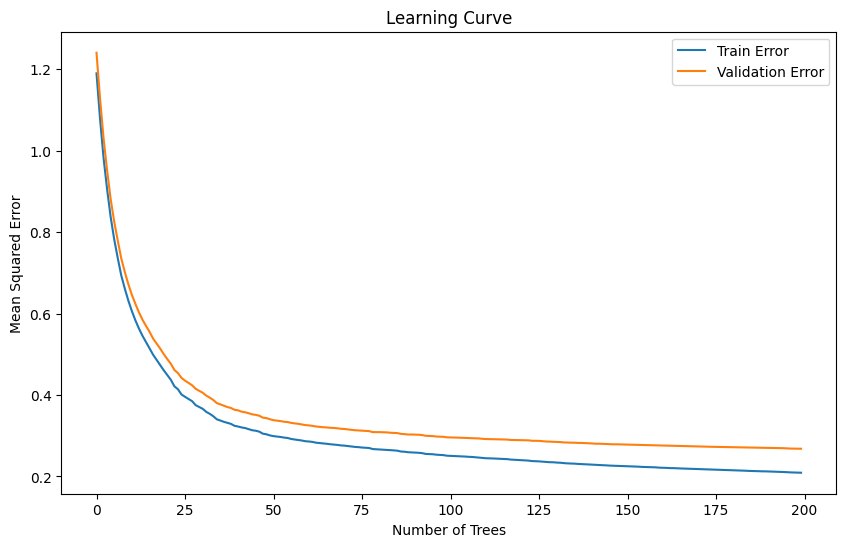

In [ ]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(gbm.train_errors)), gbm.train_errors, label="Train Error")
if gbm.val_errors:
    plt.plot(range(len(gbm.val_errors)), gbm.val_errors, label="Validation Error")
plt.xlabel("Number of Trees")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve")
plt.legend()
plt.show()

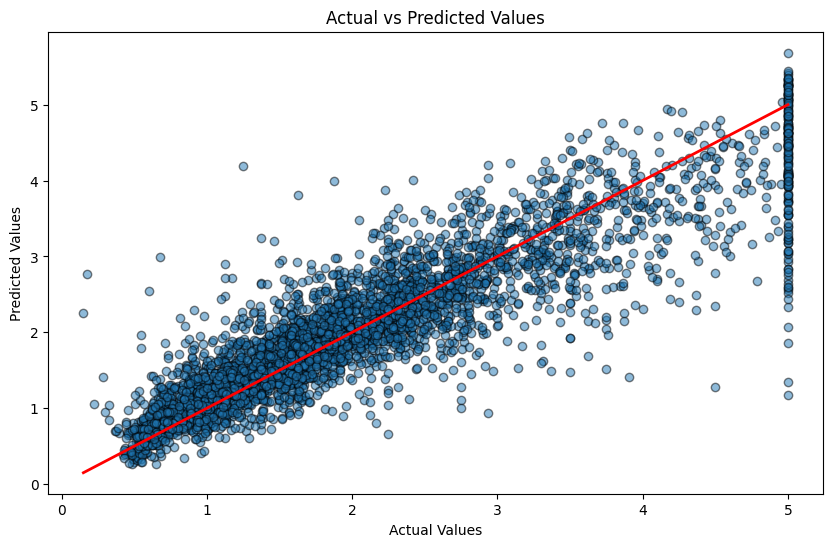

In [ ]:
# Compare predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

Gradient Boosting Machine (GBM)
Gradient Boosting Machine (GBM) is an ensemble learning method that combines the predictions of multiple weak learners (typically decision trees) to build a strong predictive model. It is widely used for both regression and classification problems due to its flexibility and high accuracy.

Key Concepts in GBM
Boosting:

Boosting is a technique where models are trained sequentially, with each new model trying to correct the errors of the previous ones.
GBM focuses on the residual errors of the model at each step.
Gradient Descent:

The method optimizes a loss function (e.g., Mean Squared Error or Log Loss) using gradient descent.
At each iteration, the residuals (errors) are treated as the negative gradient of the loss function, and a new tree is fitted to minimize these residuals.
Weighted Updates:

Predictions are updated by combining the previous predictions with the weighted predictions of the new tree.
A learning rate controls the contribution of each tree to the final model.
Steps in GBM
Initialize the Model:

Start with a simple model, often the mean of the target variable for regression or the log odds for classification.
Iterative Residual Learning:

At each step:
Compute residuals (actual values minus predicted values).
Fit a decision tree to these residuals (weak learner).
Update the predictions by adding the weighted predictions of this tree.
Repeat:

Continue iterating until the specified number of trees (n_estimators) is reached or the error stops improving (early stopping).
Final Prediction:

Combine the predictions from all trees to generate the final output.
Advantages of GBM
High accuracy and flexibility.
Can handle various loss functions (e.g., squared error, log loss).
Works well with both small and large datasets.
Disadvantages of GBM
Computationally intensive due to sequential training.
Sensitive to hyperparameters (e.g., learning rate, tree depth).
Prone to overfitting if not properly regularized.
Comparison to Other Methods
Unlike Random Forest, which trains trees independently and averages their results, GBM trains trees sequentially, with each tree focused on improving the previous one.
Advanced variants like XGBoost and LightGBM are highly optimized versions of GBM with improved speed and scalability.